# Initial Data Preparation

## Code Setup

First, let's download the necessary libraries.

In [5]:
# Standard Library Imports
import zipfile

# Third-Party Imports
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (MinMaxScaler,
                                   OneHotEncoder, PowerTransformer,
                                   StandardScaler)
from ucimlrepo import fetch_ucirepo

# libs that need to be installed
!pip install imblearn
!pip install ucimlrepo
!pip install icd9cms

# https://pypi.org/project/icd9cms/
import icd9cms

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# This will be used for plotting
def plot_odds_ratios(model, title='Odds Ratios', xlabel='Odds Ratio (OR)', ylabel='Variables', significance_level=0.05, figsize=(8, 6), name=None):
    """
    Plots odds ratios with confidence intervals from a fitted logistic regression model.
    Parameters:
    - model: Fitted statsmodels logistic regression model.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - significance_level: Threshold for statistical significance.
    - figsize: Size of the plot.
    """
    # Extract coefficients, confidence intervals, and p-values
    params = model.params
    conf = model.conf_int()
    conf.columns = ['CI_lower', 'CI_upper']
    p_values = model.pvalues

    # Calculate odds ratios and their confidence intervals
    odds_ratios = np.exp(params)
    conf_odds = np.exp(conf)

    # Create a DataFrame for plotting
    results = pd.DataFrame({
        'OR': odds_ratios,
        'CI_lower': conf_odds['CI_lower'],
        'CI_upper': conf_odds['CI_upper'],
        'p_value': p_values
    })

    # Remove the intercept
    if 'const' in results.index:
        results = results.drop('const')

    # Determine significance
    results['Significant'] = results['p_value'] < significance_level

    # Plotting
    plt.figure(figsize=figsize)
    plt.grid(False)
    # Plot each variable
    for idx, row in results.iterrows():
        plt.errorbar(row['OR'], idx,
                     xerr=[[row['OR'] - row['CI_lower']], [row['CI_upper'] - row['OR']]],
                     fmt='o',
                     color='blue' if row['Significant'] else 'grey',
                     ecolor='grey',
                     elinewidth=2,
                     capsize=8)

    # Add a vertical line at OR = 1
    plt.axvline(x=1, color='red', linestyle='--')

    # Set y-ticks to variable names
    plt.yticks(range(len(results)), results.index)
    plt.ylim(-0.5, len(results) - 0.5)  # Add some padding around the top and bottom

    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Create custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Significant (p < {significance_level})',
               markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label=f'Not Significant (p ≥ {significance_level})',
               markerfacecolor='grey', markersize=8)
    ]
    plt.legend(handles=legend_elements, loc='best')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
def check_purity_reached(df, max_purity):
    purity_dict = {}
    for col in df.columns:
        # Find the most frequent value's count and divide by the total number of rows
        most_frequent = df[col].value_counts(normalize=True).max()

        if most_frequent >= max_purity:
            purity_dict[col] = most_frequent
    return purity_dict

In [62]:
# This code is for the ANN
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
  def __init__(self, name='f1_score', **kwargs):
      super(F1Score, self).__init__(name=name, **kwargs)
      self.precision = tf.keras.metrics.Precision()
      self.recall = tf.keras.metrics.Recall()

  def update_state(self, y_true, y_pred, sample_weight=None):
      self.precision.update_state(y_true, y_pred, sample_weight)
      self.recall.update_state(y_true, y_pred, sample_weight)

  def result(self):
      precision = self.precision.result()
      recall = self.recall.result()
      return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

  def reset_state(self):
      self.precision.reset_states()
      self.recall.reset_states()

@register_keras_serializable()
def focal_loss(gamma=1, alpha=0.9):
  """
  Focal Loss for binary classification
  """
  def loss(y_true, y_pred):
      y_true = tf.cast(y_true, tf.float32)
      y_pred = tf.cast(y_pred, tf.float32)

      epsilon = tf.keras.backend.epsilon()
      y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

      cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
      weight = alpha * y_true * tf.pow((1 - y_pred), gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
      loss = weight * cross_entropy

      return tf.reduce_mean(loss)
  return loss

def find_best_threshold(y_true,
                        y_pred_prob,
                        metric,
                        thresholds=np.arange(0.0, 1.05, 0.01),
                        class_weights=None,
                        average='weighted'):
  """
  This method can be used to find the best thresholds, considering class weights if provided.
  """
  best_threshold = 0.5
  best_metric_value = 0.0

  # to store the threshold and score for plot
  thresholds_scores = []

  for threshold in thresholds:
      y_pred_class = (y_pred_prob >= threshold).astype(int)

      if metric == 'recall':
          metric_value = recall_score(y_true, y_pred_class, average=average, sample_weight=class_weights)
      elif metric == 'precision':
          metric_value = precision_score(y_true, y_pred_class, average=average, sample_weight=class_weights)
      elif metric == 'f1':
          metric_value = f1_score(y_true, y_pred_class, average=average, sample_weight=class_weights)
      else:
          raise ValueError("Unknown metric. Use 'recall', 'precision', or 'f1'.")

      # store the value
      thresholds_scores.append((threshold, metric_value))

      if metric_value > best_metric_value:
          best_threshold = threshold
          best_metric_value = metric_value

      #print(f"Threshold: {threshold:.2f}, {metric.capitalize()}: {metric_value:.4f}")

  # show a plot
  thresholds, scores = zip(*thresholds_scores)
  plt.plot(thresholds, scores)
  plt.xlabel('Threshold')
  plt.ylabel(metric.capitalize())
  plt.title(f'Threshold vs {metric.capitalize()}')
  plt.show()

  return best_threshold, best_metric_value

def plot_roc(y_test, y_pred, name="", title='Receiver Operating Characteristic'):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

# For reproducibility
tf.random.set_seed(42)

## Load Data Set

In [7]:
# Fetch dataset.
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# Import and initialize data set
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

raw_df = pd.concat([X, y], axis=1)

C:\Users\krpou\anaconda3\envs\pycharm_env\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## Create Dataset for Modeling

In [9]:
# Copies original data set.
clean_df = raw_df.copy()

# remove these columns
clean_df.drop(["weight", "max_glu_serum"], axis=1, inplace=True)

# get and drop the columns that are past maximum purity threshold
purity_dict = check_purity_reached(clean_df, max_purity=0.9995)

columns_to_remove = list(purity_dict.keys())
clean_df.drop(columns_to_remove, axis=1, inplace=True)

# The last two values are already excluded
columns_to_remove = ["payer_code", "medical_specialty", "encounter_id", "patient_nbr"]
clean_df.drop(columns_to_remove, axis=1, inplace=True, errors='ignore')

# Removes NA's from data.
numeric_cols = clean_df.select_dtypes(include=['number']).columns
categorical_cols = clean_df.select_dtypes(include=['object']).columns

clean_df[numeric_cols] = clean_df[numeric_cols].fillna(clean_df[numeric_cols].median())

for col in categorical_cols:
    clean_df[col].fillna(clean_df[col].mode()[0], inplace=True)

clean_df = clean_df[clean_df["gender"] != "Unknown/Invalid"]

#### Add new preprocessing steps

In [10]:
df = clean_df.copy()
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,No,No,No,No,Up,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,Steady,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,No,No,No,No,Up,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,Steady,No,No,No,No,Steady,No,Ch,Yes,NO


In [11]:
# include the new variables (Severity and Diagnosis Type)

## Diagnosis Type
# this code is used to get the parent description
def get_top_parent(node):
    # check if already null
    if node is None:
        return None
    # iterate until the parent is reached
    while node and node.parent is not None:
        node = node.parent
    # return the description
    return node.short_desc

# add the descriptions for the diagnoses
for column in ['diag_1', 'diag_2', 'diag_3']:
    df.loc[:, column + "_desc"] = df[column].apply(lambda code: get_top_parent(icd9cms.search(code)))

## PRIMARY DIAG (DIAG_1) SEVERITY VARIABLE
# Define severity levels for each diagnosis category
severity_mapping = {
    'Diseases Of The Circulatory System': 'High',
    'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders': 'Moderate',
    'Other': 'Low',
    'Diseases Of The Respiratory System': 'High',
    'Diseases Of The Digestive System': 'Moderate',
    'Injury And Poisoning': 'High',
    'Symptoms, Signs, And Ill-Defined Conditions': 'Low',
    'Diseases Of The Genitourinary System': 'Moderate',
    'Diseases Of The Musculoskeletal System And Connective Tissue': 'Low',
    'Mental Disorders': 'Moderate',
    'Diseases Of The Skin And Subcutaneous Tissue': 'Low'
}

df['severity'] = df['diag_1_desc'].map(severity_mapping)

# drop NaNs
df.dropna(inplace=True)

severity_order = ['Low', 'Moderate', 'High']  # Adjust based on your actual severity levels
df['severity'] = pd.Categorical(df['severity'], categories=severity_order, ordered=True)

In [12]:
# Drop the medications we aren't interested in
all_medications = df.columns[18:30] # just for reference, IG
medications_of_interest = ['chlorpropamide', 'glimepiride', 'glipizide',
                           'glyburide', 'nateglinide', 'repaglinide',
                           'pioglitazone', 'rosiglitazone', 'insulin',
                           'acarbose', 'metformin']

# there is only one medication that we are not interested in
df.drop('glyburide-metformin', axis=1, inplace=True, errors='ignore')

In [13]:
# these are the columns with the medication
df.iloc[:, 18:29]

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin
0,No,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,Up
5,No,No,No,No,No,No,No,No,No,No,Steady
6,Steady,No,No,No,Steady,No,No,No,No,No,Steady
7,No,No,No,No,No,No,Steady,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...
101759,No,No,No,No,No,No,No,No,No,No,Up
101761,Steady,No,No,No,No,No,No,No,No,No,Down
101762,No,No,No,No,No,No,No,No,No,No,Steady
101764,No,No,No,No,No,Steady,No,Steady,No,No,Up


In [14]:
# replace the medication values with 1 or 0
# because we are only interested if they are on it and not how it was changed
df.iloc[:, 18:29] = df.iloc[:, 18:29].replace(['No', 'Down', 'Steady', 'Up'], [0, 1, 1, 1])

# since we are only interested in early readmission, I'm going to change readmitted to 0 or 1.
df['readmitted'] = df['readmitted'].replace(['NO', '<30', '>30'], [0, 1, 0])

# convert severity to numeric values
severity_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
df['severity'] = df['severity'].map(severity_mapping)

# Convert these binary categorical variables into 0s and 1s
df['change'] = df['change'].replace(['No', 'Ch'], [0, 1])
df['diabetesMed'] = df['diabetesMed'].replace(['No', 'Yes'], [0, 1])

In [15]:
# for the initial dataset, we are going to drop all the diagnoses and just keep the diag_1_desc
df.drop(['diag_1', 'diag_2_desc', 'diag_3_desc'], axis=1, inplace=True)

In [16]:
no_dummy_df = df.copy()

In [17]:
# Convert categorical variables in dummy variables
categorical_vars = ['diag_2', 'diag_3', 'diag_1_desc', 'race', 'age', 'A1Cresult',
                    'gender', 'admission_type_id', 'discharge_disposition_id',
                    'admission_source_id']

df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# convert bool dtypes into int
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

### ☢️ Create transformations here

To avoid leakage, please apply the transformation after splitting the data

In [18]:
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,...,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25
0,1,41,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,31,6,16,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4,70,1,21,0,0,0,7,1,0,...,0,0,0,0,0,0,0,0,0,0
7,5,73,0,12,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0


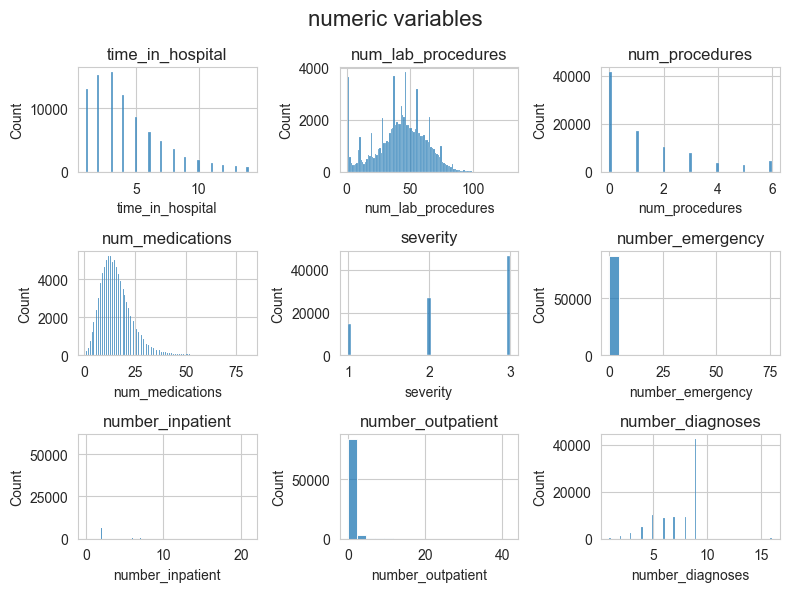

In [20]:
import seaborn as sns
def plot_numeric(dataset, title='numeric variables', figsize=(8, 6)):
  # show 3x3 grid for variables
  numeric_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                    'num_medications', 'severity', 'number_emergency',
                    'number_inpatient', 'number_outpatient', 'number_diagnoses']

  # show density plot subplots
  # create subplot
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)

  # boxplot each numeric feature
  for i, col in enumerate(numeric_features):
    # check if column exists
    if col in dataset.columns:
      # conver the value to numeric
      feature = pd.to_numeric(dataset[col], errors='coerce')
      sns.histplot(data=feature, ax=axes[i // 3, i % 3])
      axes[i // 3, i % 3].set_title(col)

  plt.suptitle(title, fontsize=16)
  plt.tight_layout()
  plt.show()

plot_numeric(df)

In [21]:
"""
Block where transformations will go. You can add one below.
"""
def transformation_one(df, fitted_transformers = None):
    transformed_df = df.copy()

    ## Remove Inpatient, Outpatient, number_diagnoses
    # becuase inpatient and outpaitent have very unbalanced classes, they would
    # worsen model performance. My reasoning is that there will be a bias towards
    # more frequent hospital visitors.
    # Lastly, number_diagnoses has a very week correlation with <30 readmission
    transformed_df.drop(['number_inpatient', 'number_outpatient', 'number_diagnoses'],
                        axis=1, errors='ignore', inplace=True)

    # variables for power transform
    transformed_df.loc[:, 'num_lab_procedures'] += 1 # values can't be zero for power transform
    boxcox_variables = ["time_in_hospital", "num_medications", "num_lab_procedures"]

    # variables to normalize
    minmax_variables = ["severity", "num_procedures", "number_emergency",
                        "time_in_hospital", "num_lab_procedures"]

    # check if any transformers were provided
    if fitted_transformers == None:
        # create the transformation objects
        fitted_transformers = {}
        fitted_transformers['power'] = PowerTransformer(method='box-cox')
        fitted_transformers['minmax'] = MinMaxScaler()

        # deskew the data points (only works with positive values)
        transformed_df[boxcox_variables] = fitted_transformers['power'].fit_transform(transformed_df[boxcox_variables])

        # Normalize the columns
        transformed_df[minmax_variables] = fitted_transformers['minmax'].fit_transform(transformed_df[minmax_variables])

        print("fitting and transforming")
        return (transformed_df, fitted_transformers)
    else:
        # deskew the data points (only works with positive values)
        transformed_df[boxcox_variables] = fitted_transformers['power'].transform(transformed_df[boxcox_variables])

        # Normalize the columns
        transformed_df[minmax_variables] = fitted_transformers['minmax'].transform(transformed_df[minmax_variables])

        print("transforming")
        return transformed_df


def transformation_two(df, fitted_transformers = None):
    """
    similiar to one.
    Clip number_emergency to 2
    """
    transformed_df = df.copy()

    # convert number of emergencies to be [0, 1, 2+], but first remove outliers
    transformed_df = transformed_df[transformed_df['number_emergency'] <= 25]
    transformed_df.loc[:, ['number_emergency']] = transformed_df['number_emergency'].clip(upper=2)

    # drop irrelevant columns
    transformed_df.drop(['number_inpatient', 'number_outpatient', 'number_diagnoses'],
                        axis=1, errors='ignore', inplace=True)

    # variables for power transform
    transformed_df.loc[:, 'num_lab_procedures'] += 1 # values can't be zero for power transform
    boxcox_variables = ["time_in_hospital", "num_medications", "num_lab_procedures"]

    # variables to normalize
    minmax_variables = ["severity", "num_procedures", "number_emergency",
                        "time_in_hospital", "num_lab_procedures"]

    # check if any transformers were provided
    if fitted_transformers == None:
        # create the transformation objects
        fitted_transformers = {}
        fitted_transformers['power'] = PowerTransformer(method='box-cox')
        fitted_transformers['minmax'] = MinMaxScaler()

        # deskew the data points (only works with positive values)
        transformed_df[boxcox_variables] = fitted_transformers['power'].fit_transform(transformed_df[boxcox_variables])

        # Normalize the columns
        transformed_df[minmax_variables] = fitted_transformers['minmax'].fit_transform(transformed_df[minmax_variables])

        print("fitting and transforming")
        return (transformed_df, fitted_transformers)
    else:
        # deskew the data points (only works with positive values)
        transformed_df[boxcox_variables] = fitted_transformers['power'].transform(transformed_df[boxcox_variables])

        # Normalize the columns
        transformed_df[minmax_variables] = fitted_transformers['minmax'].transform(transformed_df[minmax_variables])

        print("transforming")
        return transformed_df

def transformation_five(df, fitted_transformers = None):
    """
    similiar to one.
    Clip number_emergency to 2
    standardize num_medications
    """
    transformed_df = df.copy()

    # convert number of emergencies to be [0, 1, 2+], but first remove outliers
    transformed_df = transformed_df[transformed_df['number_emergency'] <= 25]
    transformed_df.loc[:, ['number_emergency']] = transformed_df['number_emergency'].clip(upper=2)

    # drop irrelevant columns
    transformed_df.drop(['number_inpatient', 'number_outpatient', 'number_diagnoses'],
                        axis=1, errors='ignore', inplace=True)

    # variables for power transform
    transformed_df.loc[:, 'num_lab_procedures'] += 1 # values can't be zero for power transform
    boxcox_variables = ["time_in_hospital", "num_lab_procedures"]

    # variables to normalize
    minmax_variables = ["severity", "num_procedures", "number_emergency",
                        "time_in_hospital", "num_lab_procedures"]

    # check if any transformers were provided
    if fitted_transformers == None:
        # create the transformation objects
        fitted_transformers = {}
        fitted_transformers['power'] = PowerTransformer(method='box-cox')
        fitted_transformers['minmax'] = MinMaxScaler()
        fitted_transformers['std_scaler'] = StandardScaler()

        # standarize num_medications
        transformed_df.loc[:, 'num_medications'] = fitted_transformers['std_scaler'].fit_transform(transformed_df[['num_medications']])

        # deskew the data points (only works with positive values)
        transformed_df[boxcox_variables] = fitted_transformers['power'].fit_transform(transformed_df[boxcox_variables])

        # Normalize the columns
        transformed_df[minmax_variables] = fitted_transformers['minmax'].fit_transform(transformed_df[minmax_variables])

        print("fitting and transforming")
        return (transformed_df, fitted_transformers)
    else:
        # standarize num_medications
        transformed_df.loc[:, 'num_medications'] = fitted_transformers['std_scaler'].transform(transformed_df[['num_medications']])

        # deskew the data points (only works with positive values)
        transformed_df[boxcox_variables] = fitted_transformers['power'].transform(transformed_df[boxcox_variables])

        # Normalize the columns
        transformed_df[minmax_variables] = fitted_transformers['minmax'].transform(transformed_df[minmax_variables])

        print("transforming")
        return transformed_df

##### Test and Compare Your Transformations

In [ ]:
"""
This code is used to test out different variable changes. [Use Validation Set]
"""
print("\n\n")
################ Split the Dataset into Train/Test/Val #########################
# 1. Split the datasets
train_df, test_df = train_test_split(df, test_size=0.4,
                                     random_state=42, stratify=df["readmitted"])

# split the test into validation and test
test_df, val_df = train_test_split(test_df, test_size=0.5,
                                   random_state=42, stratify=test_df["readmitted"])

###################### Apply the Transformation ################################

# transformations_to_test = [transformation_one, transformation_two, transformation_five]
transformations_to_test = [] # transformations to test go here

for transformation in transformations_to_test:
  print(f"Testing {transformation.__name__}")
  _, scalers = transformation(train_df) # get the scalers
  trans_val_df = transformation(val_df, fitted_transformers = scalers)

################## Test Accuracy on Validation Set #############################

  # Split the data into training and test sets
  X_val, y_val = trans_val_df.drop('readmitted', axis=1), trans_val_df['readmitted']

  # Initialize logistic regression with regularization
  log_reg = LogisticRegression(class_weight='balanced',
                              penalty='l2',
                              solver='liblinear',
                              random_state=42,
                              max_iter=100)

  log_reg.fit(X_val, y_val)

  y_pred = log_reg.predict(X_val)
  print(classification_report(y_val, y_pred))

### Generate train/test/val dataset with transformation

In [22]:
# This creates test_df, train_df, and val_df
test_size = 0.2

# Split the datasets
train_df, test_df = train_test_split(df, test_size=test_size,
                                     random_state=42, stratify=df["readmitted"])

# Split the test into validation and test
test_df, val_df = train_test_split(test_df, test_size=0.5,
                                   random_state=42, stratify=test_df["readmitted"])


# Fit/transform on train, transofrm the other sets to avoid leakge
train_df, scalers = transformation_two(train_df)

# Transform test and val
test_df = transformation_two(test_df, fitted_transformers = scalers)
val_df = transformation_two(val_df, fitted_transformers = scalers)

# Print number of observations in each
print(f"\nTrain: {train_df.shape[0]}")
print(f"Test: {test_df.shape[0]}")
print(f"Val: {val_df.shape[0]}")

fitting and transforming
transforming
transforming

Train: 70466
Test: 8808
Val: 8806


In [23]:
# Split the data into training and test sets
X_train, y_train = train_df.drop('readmitted', axis=1), train_df['readmitted']
X_test, y_test = test_df.drop('readmitted', axis=1), test_df['readmitted']
X_val, y_val = val_df.drop('readmitted', axis=1), val_df['readmitted']

## Data Modeling

### Logistic Regression

#### Base Model

In [24]:
from sklearn.linear_model import LogisticRegressionCV

log_reg = LogisticRegressionCV(class_weight='balanced',
                               penalty='l2',
                               solver='liblinear',
                               random_state=42)

log_reg.fit(X_train, y_train)

# Evaluate the model
print("Train Accuracy:", log_reg.score(X_train, y_train))
print("Test Accuracy:", log_reg.score(X_test, y_test))

Train Accuracy: 0.6357392217523344
Test Accuracy: 0.6267029972752044


In [ ]:
# save the model
# import pickle
# pickle.dump(log_reg, open('best_performing_model_logreg.pkl', 'wb'))

In [ ]:
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

print("Best performing logistic Regression model (Shih et al.):")
print("Acc     precision  recall  f1-score  specificity  ")
print("63.57%  0.640      0.621   0.63      0.62")

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      7828
           1       0.16      0.56      0.25       980

    accuracy                           0.63      8808
   macro avg       0.54      0.60      0.50      8808
weighted avg       0.84      0.63      0.70      8808

Best performing logistic Regression model (Shih et al.):
Acc     precision  recall  f1-score  specificity  
63.57%  0.640      0.621   0.63      0.62


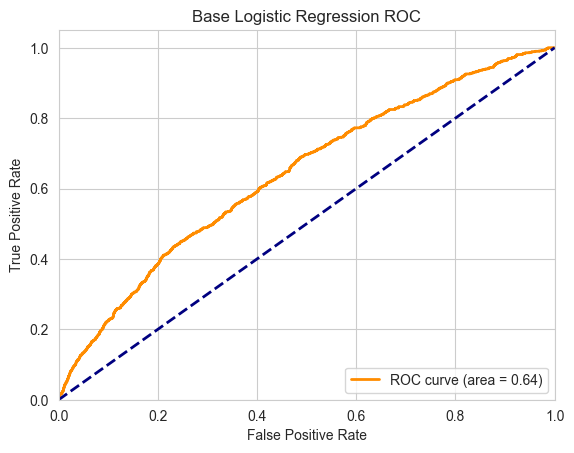

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base Logistic Regression ROC')
plt.legend(loc="lower right")
plt.show()

AUCs for predicting early readmission

From Alloghani et al.

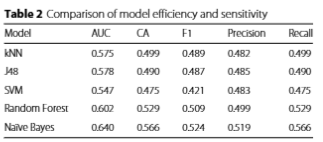

#### Base Model (with data oversampling)

I found that ADASYN provides the best 'recall' score compared to SMOTE and RandomOverSampler. However, oversampled data does dramatically worse than the base model.

In [ ]:
# perform a grid search for the best parameters
from tqdm import tqdm
import numpy as np

from imblearn.over_sampling import ADASYN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

# Create the ADASYN object
adasyn = ADASYN(random_state=0.5)

# Define parameter grid for GridSearch
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'sampling_strategy': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
}

best_params = None
best_val_score = -np.inf  # Keep track of best validation score
best_model = None

# Loop through grid parameters
for params in tqdm(ParameterGrid(param_grid), desc="Hyperparameter Tuning"):
  n_neighbors = params['n_neighbors']
  sampling_strategy = params['sampling_strategy']

  # ADASYN with given parameters
  adasyn = ADASYN(n_neighbors=n_neighbors, sampling_strategy=sampling_strategy)

  # Apply ADASYN to the training data
  X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

  # Train the classifier on resampled data
  classifier = LogisticRegression(class_weight='balanced',
                          penalty='l2',
                          solver='liblinear', max_iter=5,
                          random_state=42)
  classifier.fit(X_resampled, y_resampled)

  # Validate on the validation set
  y_val_pred = classifier.predict(X_val)
  val_score = f1_score(y_val, y_val_pred)

  # Update best model if current model is better
  if val_score > best_val_score:
      best_val_score = val_score
      best_params = {'n_neighbors': n_neighbors, 'sampling_strategy': sampling_strategy}
      best_model = classifier

# Output the best parameters and validation score
print(f"Best Params: {best_params}")
print(f"Best Validation Score: {best_val_score}")

# Best Params: {'n_neighbors': 3, 'sampling_strategy': 0.5} || Best Validation Score: 0.11417322834645667

Hyperparameter Tuning:   0%|          | 0/30 [00:00<?, ?it/s]

Best Params: {'n_neighbors': 3, 'sampling_strategy': 0.5}

Best Validation Score: 0.11417322834645667

Test F1-score: 0.11896893588896233

In [26]:
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_curve

# oversample data with SMOTE
adasyn = ADASYN(random_state=42, n_neighbors=3, sampling_strategy=0.5)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# Initialize logistic regression with regularization
log_reg_2 = LogisticRegressionCV(class_weight='balanced',
                               penalty='l2',
                               solver='liblinear',
                                 max_iter=1000,
                               random_state=42)

log_reg_2.fit(X_train_balanced, y_train_balanced)

# Evaluate the model
print("Train Accuracy:", log_reg_2.score(X_train_balanced, y_train_balanced))
print("Test Accuracy:", log_reg_2.score(X_test, y_test))

Train Accuracy: 0.8925335006991929
Test Accuracy: 0.8711398728428701


In [27]:
y_pred = log_reg_2.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
# Best performing logistic Regression model (Shih et al.):
# Acc     precision  recall  specificity
# 63.57%  0.640      0.621   0.62

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      7828
           1       0.24      0.07      0.11       980

    accuracy                           0.87      8808
   macro avg       0.56      0.52      0.52      8808
weighted avg       0.82      0.87      0.84      8808

ROC AUC Score: 0.5208964679382229


### Decision Tree

Decision trees with well with data with outliers. For this reason I'm going to use the dataset without the dummie variable and extra transformations.

In [34]:
# 1. Split the datasets
train_df, test_df = train_test_split(df, test_size=0.4,
                                     random_state=42, stratify=df["readmitted"])

# Split the test into validation and test
test_df, val_df = train_test_split(test_df, test_size=0.5,
                                   random_state=42, stratify=test_df["readmitted"])


# 2. fit/transform on train, transform the other sets to avoid leakge
train_df, scalers = transformation_two(train_df)

# transform test and val
test_df = transformation_two(test_df, fitted_transformers = scalers)
val_df = transformation_two(val_df, fitted_transformers = scalers)

# Split the data into training and test sets
X_train, y_train = train_df.drop('readmitted', axis=1), train_df['readmitted']
X_test, y_test = test_df.drop('readmitted', axis=1), test_df['readmitted']

fitting and transforming
transforming
transforming


##### Decision Tree

Tree with no oversampling

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Create a DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42      # For reproducibility
)

# Fit the classifier to your data
decision_tree.fit(X_train, y_train)

# evaluate the model
print("Train Accuracy:", decision_tree.score(X_train, y_train))
print("Test Accuracy:", decision_tree.score(X_test, y_test))

0.8893640371624818
Test Accuracy: 0.888176193449509


In [36]:
y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15658
           1       0.08      0.00      0.00      1959

    accuracy                           0.89     17617
   macro avg       0.48      0.50      0.47     17617
weighted avg       0.80      0.89      0.84     17617

ROC AUC Score: 0.49987204156011883


Tree with default SMOTE oversampling

In [38]:
# Applying SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Create a DecisionTreeClassifier
decision_tree_2 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42      # For reproducibility
)

# Fit the classifier to your data
decision_tree_2.fit(X_train_balanced, y_train_balanced)

# evaluate the model
print("Train Accuracy:", decision_tree_2.score(X_train, y_train))
print("Test Accuracy:", decision_tree_2.score(X_test, y_test))

Train Accuracy: 0.5147117258604704
Test Accuracy: 0.5206902423795198


In [39]:
y_pred = decision_tree_2.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.51      0.66     15658
           1       0.13      0.57      0.21      1959

    accuracy                           0.52     17617
   macro avg       0.52      0.54      0.43     17617
weighted avg       0.82      0.52      0.61     17617

ROC AUC Score: 0.5434596252164128


Tree with default ADASYN oversampling

In [40]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# Create a DecisionTreeClassifier
decision_tree_3 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42      # For reproducibility
)

# Fit the classifier to your data
decision_tree_3.fit(X_train_balanced, y_train_balanced)

# evaluate the model
print("Train Accuracy:", decision_tree_3.score(X_train, y_train))
print("Test Accuracy:", decision_tree_3.score(X_test, y_test))

Train Accuracy: 0.5147306476943745
Test Accuracy: 0.5206902423795198


In [41]:
y_pred = decision_tree_3.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.51      0.66     15658
           1       0.13      0.57      0.21      1959

    accuracy                           0.52     17617
   macro avg       0.52      0.54      0.43     17617
weighted avg       0.82      0.52      0.61     17617

ROC AUC Score: 0.5434596252164128


##### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# Create a RandomForestClassifier
random_forest_model = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=None, 
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42       # For reproducibility
)

# Fit the classifier to your data
random_forest_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [43]:
y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93     15658
           1       0.19      0.07      0.10      1959

    accuracy                           0.86     17617
   macro avg       0.54      0.52      0.51     17617
weighted avg       0.81      0.86      0.83     17617

ROC AUC Score: 0.5153928461028032


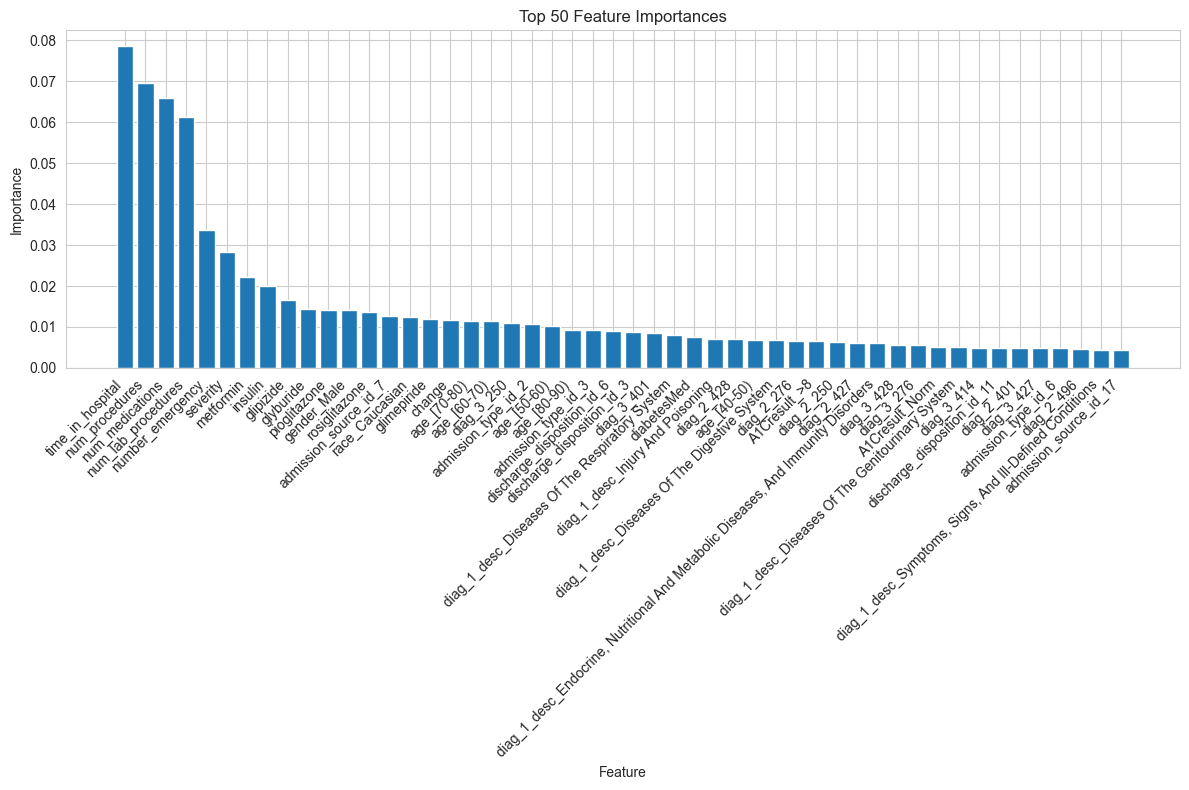

In [44]:
# Get feature importances
importances = random_forest_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Select the top 50 features
top_50_features = feature_importances_df.head(50)

# Plot feature importances for the top 50 features
plt.figure(figsize=(12, 8))
plt.bar(top_50_features['feature'], top_50_features['importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 50 Feature Importances')
plt.tight_layout()
plt.show()

### Neural Network

In [47]:
# 1. Split the datasets
train_df, test_df = train_test_split(df, test_size=0.2,
                                     random_state=42, stratify=df["readmitted"])

# split the test into validation and test
test_df, val_df = train_test_split(test_df, test_size=0.5,
                                   random_state=42, stratify=test_df["readmitted"])


# 2. fit/tranform on train, transofrm the other sets to avoid leakge
train_df, scalers = transformation_two(train_df)

# transform test and val
test_df = transformation_two(test_df, fitted_transformers = scalers)
val_df = transformation_two(val_df, fitted_transformers = scalers)

# Split the data into training and test sets
X_train, y_train = train_df.drop('readmitted', axis=1), train_df['readmitted']
X_test, y_test = test_df.drop('readmitted', axis=1), test_df['readmitted']
X_val, y_val = val_df.drop('readmitted', axis=1), val_df['readmitted']

fitting and transforming
transforming
transforming


In [48]:
# samples in each set
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Train set: 70466 samples
Test set: 8808 samples
Validation set: 8806 samples


#### model creation

In [60]:
import tensorflow as tf

X_train = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val.values, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val.values, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test.values, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

##### Base NN Model

In [63]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

# Create the ANN model
base_ann_model = Sequential()
base_ann_model.add(Input(shape=(X_train.shape[1],)))
base_ann_model.add(Dense(64, activation='relu'))
base_ann_model.add(Dense(32, activation='relu'))
base_ann_model.add(Dense(1, activation='sigmoid'))

# Compile the model with a focus on recall
base_ann_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[F1Score()])

# Train the model using class weights
base_ann_model.fit(X_train, y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_val, y_val))

Epoch 1/10
2203/2203 [==============================] - 8s 3ms/step - loss: 0.3437 - f1_score: 0.0018 - val_loss: 0.3385 - val_f1_score: 0.0000e+00
Epoch 2/10
2203/2203 [==============================] - 6s 3ms/step - loss: 0.3318 - f1_score: 0.0000e+00 - val_loss: 0.3369 - val_f1_score: 0.0000e+00
Epoch 3/10
2203/2203 [==============================] - 6s 3ms/step - loss: 0.3264 - f1_score: 2.5510e-04 - val_loss: 0.3418 - val_f1_score: 0.0000e+00
Epoch 4/10
2203/2203 [==============================] - 5s 2ms/step - loss: 0.3184 - f1_score: 0.0141 - val_loss: 0.3461 - val_f1_score: 0.0081
Epoch 5/10
2203/2203 [==============================] - 5s 2ms/step - loss: 0.3082 - f1_score: 0.0696 - val_loss: 0.3561 - val_f1_score: 0.0216
Epoch 6/10
2203/2203 [==============================] - 5s 2ms/step - loss: 0.2947 - f1_score: 0.1527 - val_loss: 0.3705 - val_f1_score: 0.0159
Epoch 7/10
2203/2203 [==============================] - 5s 2ms/step - loss: 0.2818 - f1_score: 0.2266 - val_loss: 0.

276/276 [==============================] - 0s 1ms/step


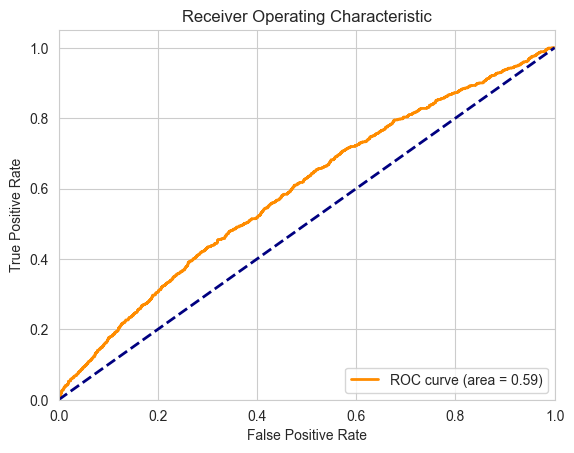

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      7828
         1.0       0.21      0.07      0.10       980

    accuracy                           0.87      8808
   macro avg       0.55      0.52      0.51      8808
weighted avg       0.82      0.87      0.84      8808



In [64]:
from sklearn.metrics import roc_curve, auc
y_pred = base_ann_model.predict(X_test)
plot_roc(y_test, y_pred)

y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

##### NN Model 2

In [ ]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

# Define the parameter grid for alpha and gamma
param_grid = {
    'alpha': [0.25, 0.5, 0.75],
    'gamma': [0.5, 1, 2]
}


early_stopping = EarlyStopping(monitor='f1_score',
                               patience=3,
                               restore_best_weights=True,
                               mode='max')

best_params = None
best_score = 0

# Iterate through the parameter grid
for params in tqdm(list(ParameterGrid(param_grid))):
    """⚠️ Added 'continue' below to not waste time with another grid search on accident"""
    continue
    alpha = params['alpha']
    gamma = params['gamma']
    
    # Create the model with the current parameters
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                loss=focal_loss(gamma=gamma, alpha=alpha),
                metrics=[F1Score()])
    
    # Train the model
    model.fit(X_train, y_train,
            batch_size=256,
            epochs=10,
            callbacks=[early_stopping],
            verbose=0)
    
    # Evaluate the model on the validation set
    loss, f1_score = model.evaluate(X_val, y_val, verbose=0)
    
    # Update best parameters if F1-score is improved
    if f1_score > best_score:
      best_score = f1_score
      best_params = params

print("Best parameters:", best_params)
print("Best score:", best_score)

# for best recall 0.476; gamma = 1, alpha = 0.9
# for best loss - Best parameters: {'alpha': 0.15, 'gamma': 2.5}
# Best parameters: {'alpha': 0.75, 'gamma': 1} Best score: 0.07551020383834839 # best recall

100%|██████████| 9/9 [00:00<00:00, 6838.54it/s]


In [66]:
# use the fine tuned parameters
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_f1_score',
                               patience=10,
                               restore_best_weights=True,
                               mode='max')

# Create the ANN model
ann_model2 = Sequential()
ann_model2.add(Input(shape=(X_train.shape[1],)))
ann_model2.add(Dense(64, activation='relu'))
ann_model2.add(Dense(32, activation='relu'))
ann_model2.add(Dense(1, activation='sigmoid'))

ann_model2.compile(optimizer='adam',
              loss=focal_loss(alpha = 0.75, gamma = 0.5), # using the fine-tune parameters
              metrics=[F1Score()])

# Train the model using class weights
ann_model2.fit(x=X_train, y=y_train,
              epochs=100,
              batch_size=256,
              validation_data=(X_val, y_val),
              callbacks=early_stopping)

Epoch 1/100
276/276 [==============================] - 2s 5ms/step - loss: 0.1238 - f1_score: 0.0023 - val_loss: 0.1218 - val_f1_score: 0.0159
Epoch 2/100
276/276 [==============================] - 1s 4ms/step - loss: 0.1188 - f1_score: 0.0783 - val_loss: 0.1218 - val_f1_score: 0.0653
Epoch 3/100
276/276 [==============================] - 1s 4ms/step - loss: 0.1160 - f1_score: 0.1689 - val_loss: 0.1230 - val_f1_score: 0.1070
Epoch 4/100
276/276 [==============================] - 1s 4ms/step - loss: 0.1121 - f1_score: 0.2378 - val_loss: 0.1254 - val_f1_score: 0.1468
Epoch 5/100
276/276 [==============================] - 1s 4ms/step - loss: 0.1073 - f1_score: 0.3049 - val_loss: 0.1301 - val_f1_score: 0.1977
Epoch 6/100
276/276 [==============================] - 1s 4ms/step - loss: 0.1020 - f1_score: 0.3661 - val_loss: 0.1347 - val_f1_score: 0.1554
Epoch 7/100
276/276 [==============================] - 1s 4ms/step - loss: 0.0968 - f1_score: 0.4045 - val_loss: 0.1389 - val_f1_score: 0.1700

276/276 [==============================] - 0s 1ms/step


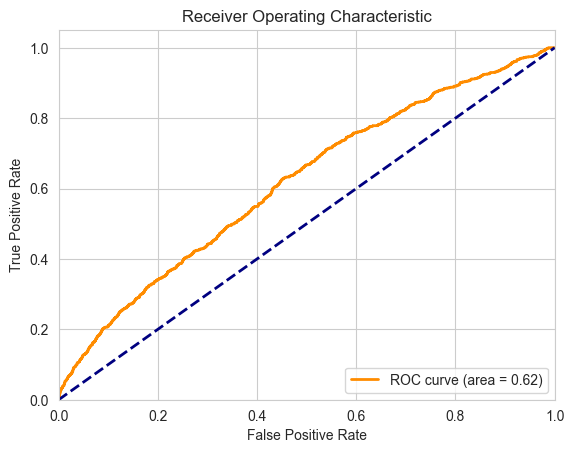

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      7828
         1.0       0.21      0.22      0.21       980

    accuracy                           0.82      8808
   macro avg       0.55      0.56      0.55      8808
weighted avg       0.82      0.82      0.82      8808



In [67]:
y_pred = ann_model2.predict(X_test)
plot_roc(y_test, y_pred)

y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

276/276 [==============================] - 0s 1ms/step


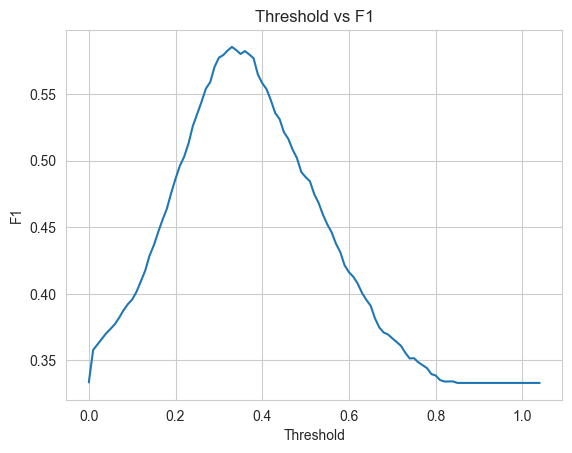


Best threshold for score: 0.33 with score: 0.5855
276/276 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.54      0.68      7828
         1.0       0.15      0.63      0.24       980

    accuracy                           0.55      8808
   macro avg       0.53      0.59      0.46      8808
weighted avg       0.84      0.55      0.64      8808



In [69]:
from sklearn.metrics import f1_score
# find the best threshold (other than >= 0.5) for model
# ⚠️ using the validation set to avoid data leakage

# get a list of the class weights for every y value (e.g., [.25, .25 .75, .25 ...])
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights_dict = dict(enumerate(class_weights))
weights_list = [class_weights_dict[i] for i in list(y_val.numpy())]

# get the best value and print it (f1, precision, or recall)
y_pred_prob = ann_model2.predict(X_val)
best_threshold, best_f1 = find_best_threshold(y_val, y_pred_prob,
                                              metric='f1',
                                              average='weighted',
                                              class_weights=weights_list)
print(f"\nBest threshold for score: {best_threshold:.2f} with score: {best_f1:.4f}")

# show the best results
y_pred = ann_model2.predict(X_test)
y_pred = (y_pred >= best_threshold).astype(int)
print(classification_report(y_test, y_pred))

276/276 [==============================] - 0s 1ms/step


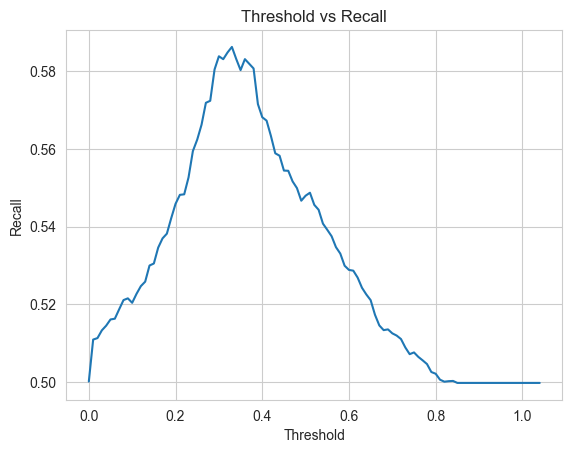


Best threshold for score: 0.33 with score: 0.5863
              precision    recall  f1-score   support

         0.0       0.92      0.54      0.68      7828
         1.0       0.15      0.63      0.24       980

    accuracy                           0.55      8808
   macro avg       0.53      0.59      0.46      8808
weighted avg       0.84      0.55      0.64      8808



In [70]:
# get the best value and print it (f1, precision, or recall)
y_pred = ann_model2.predict(X_test)
y_pred_prob = ann_model2.predict(X_val)
best_threshold, best_f1 = find_best_threshold(y_val, y_pred_prob,
                                              metric='recall',
                                              average='weighted',
                                              class_weights=weights_list)
print(f"\nBest threshold for score: {best_threshold:.2f} with score: {best_f1:.4f}")

y_pred = (y_pred >= best_threshold).astype(int)
print(classification_report(y_test, y_pred))

##### ann model 3 (parameter grid search and more layers/units)

In [ ]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Define the parameter grid for alpha and gamma
param_grid = {
    'alpha': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0],
    'gamma': [1.5, 1.75, 2, 2.25, 2.5, 3, 4]
}

# to keep track
best_params = None
best_score = -np.inf

# use the finetuned parameters
early_stopping = EarlyStopping(monitor='val_f1_score',
                              patience=10,
                              restore_best_weights=True,
                              mode='max')

for params in tqdm(list(ParameterGrid(param_grid))):
  """⚠️ Added 'continue' below to not waste time with another grid search on accident"""
  continue
  alpha = params['alpha']
  gamma = params['gamma']

  # Create the ANN model
  ann_model3 = Sequential()
  ann_model3.add(Input(shape=(X_train.shape[1],)))  # Correct way to define input shape
  ann_model3.add(Dense(64, activation='relu'))
  ann_model3.add(Dense(64, activation='relu'))
  ann_model3.add(Dense(1, activation='sigmoid'))

  ann_model3.compile(optimizer='adam',
                loss=focal_loss(alpha = alpha, gamma = gamma), # using the fine-tune parameters
                metrics=[F1Score()])

  # Train the model using class weights
  ann_model3.fit(x=X_train,
                 y=y_train,
                 epochs=100,
                 batch_size=256,
                 validation_data=(X_val, y_val),
                 callbacks=early_stopping)

  # use validation for param
  loss, f1_score = ann_model3.evaluate(X_val, y_val)

  # Update best parameters if F1-score is improved
  if f1_score > best_score:
      best_score = f1_score
      best_params = params

# alpha = 0.9, gamma = 1.5
print("Best parameters:", best_params)
print("Best score:", best_score)

100%|██████████| 49/49 [00:00<00:00, 72366.51it/s]

Best parameters: None
Best score: -inf


Epoch 1/100
551/551 [==============================] - 2s 3ms/step - loss: 0.0456 - f1_score: 0.2152 - val_loss: 0.0451 - val_f1_score: 0.2298
Epoch 2/100
551/551 [==============================] - 2s 3ms/step - loss: 0.0445 - f1_score: 0.2424 - val_loss: 0.0446 - val_f1_score: 0.2423
Epoch 3/100
551/551 [==============================] - 1s 3ms/step - loss: 0.0438 - f1_score: 0.2551 - val_loss: 0.0444 - val_f1_score: 0.2428
Epoch 4/100
551/551 [==============================] - 2s 3ms/step - loss: 0.0432 - f1_score: 0.2617 - val_loss: 0.0445 - val_f1_score: 0.2385
Epoch 5/100
551/551 [==============================] - 2s 3ms/step - loss: 0.0428 - f1_score: 0.2688 - val_loss: 0.0444 - val_f1_score: 0.2426
Epoch 6/100
551/551 [==============================] - 2s 3ms/step - loss: 0.0424 - f1_score: 0.2735 - val_loss: 0.0446 - val_f1_score: 0.2448
Epoch 7/100
551/551 [==============================] - 1s 3ms/step - loss: 0.0420 - f1_score: 0.2786 - val_loss: 0.0446 - val_f1_score: 0.2407

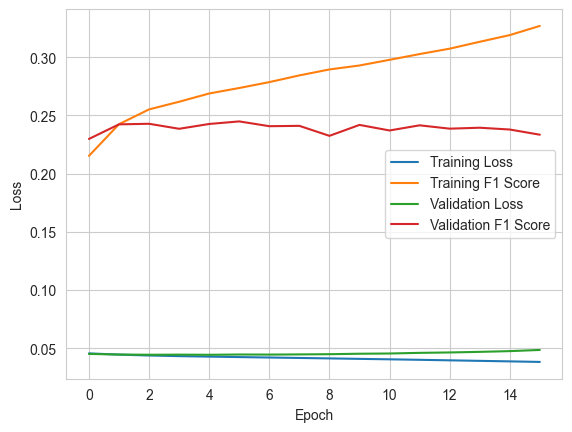

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# use the finetuned parameters
early_stopping = EarlyStopping(monitor='val_f1_score',
                              patience=10,
                              restore_best_weights=True,
                              mode='max')

# Create the ANN model
ann_model3 = Sequential()
ann_model3.add(Input(shape=(X_train.shape[1],)))  # Correct way to define input shape
ann_model3.add(Dense(64, activation='relu'))
ann_model3.add(Dense(64, activation='relu'))
ann_model3.add(Dense(1, activation='sigmoid'))


ann_model3.compile(optimizer=Adam(learning_rate=0.0001),
              loss=focal_loss(alpha = 0.9, gamma = 1.5), # using the fine-tune parameters
              metrics=[F1Score()])

# Train the model using class weights
history = ann_model3.fit(x=X_train,
                y=y_train,
                epochs=100,
                batch_size=128,
                validation_data=(X_val, y_val),
                callbacks=early_stopping)

# plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

276/276 [==============================] - 0s 1ms/step


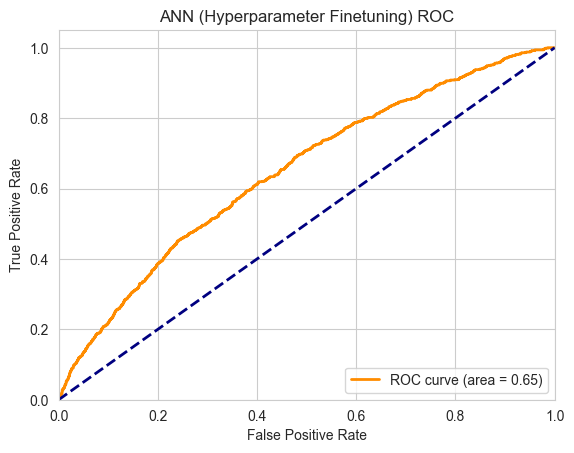

              precision    recall  f1-score   support

         0.0       0.92      0.63      0.75      7828
         1.0       0.16      0.58      0.26       980

    accuracy                           0.63      8808
   macro avg       0.54      0.60      0.50      8808
weighted avg       0.84      0.63      0.70      8808



In [84]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc

y_pred = ann_model3.predict(X_test)
plot_roc(y_test, y_pred, name='ann_finetune_roc_curve', title="ANN (Hyperparameter Finetuning) ROC")

y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

276/276 [==============================] - 0s 1ms/step


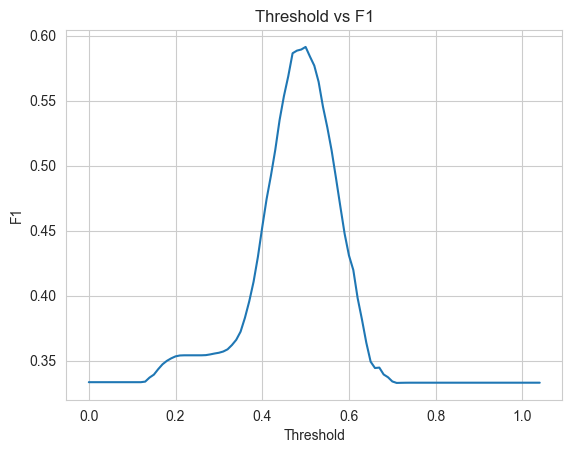


Best threshold for score: 0.50 with score: 0.5913
276/276 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.63      0.75      7828
         1.0       0.16      0.58      0.26       980

    accuracy                           0.63      8808
   macro avg       0.54      0.60      0.50      8808
weighted avg       0.84      0.63      0.70      8808



In [85]:
from sklearn.metrics import f1_score
# get the best value and print it (f1, precision, or recall)
y_pred_prob = ann_model3.predict(X_val)
best_threshold, best_f1 = find_best_threshold(y_val, y_pred_prob,
                                              metric='f1',
                                              average='weighted',
                                              class_weights=weights_list)
print(f"\nBest threshold for score: {best_threshold:.2f} with score: {best_f1:.4f}")

# show the best results
y_pred = ann_model3.predict(X_test)
y_pred = (y_pred >= best_threshold).astype(int)
print(classification_report(y_test, y_pred))